# Advanced Spectrum List Patterns and Workarounds

`muler` is built on specutils, which has many spectrum list operations, but not everything we'd ideally want.  In this notebook, we introduce a few workarounds to deal with common patterns.

In [1]:
%config Completer.use_jedi = False

In [2]:
from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList
from specutils import Spectrum1D, SpectrumList
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Simply tell the IGRINS Spectrum where your file is located.

In [3]:
fn = '../../tests/data/muler_example_data/IGRINS/01_IGRINS_test_data/SDCH_20201202_0059.spec_a0v.fits'
spec_list = IGRINSSpectrumList.read(fn).normalize()

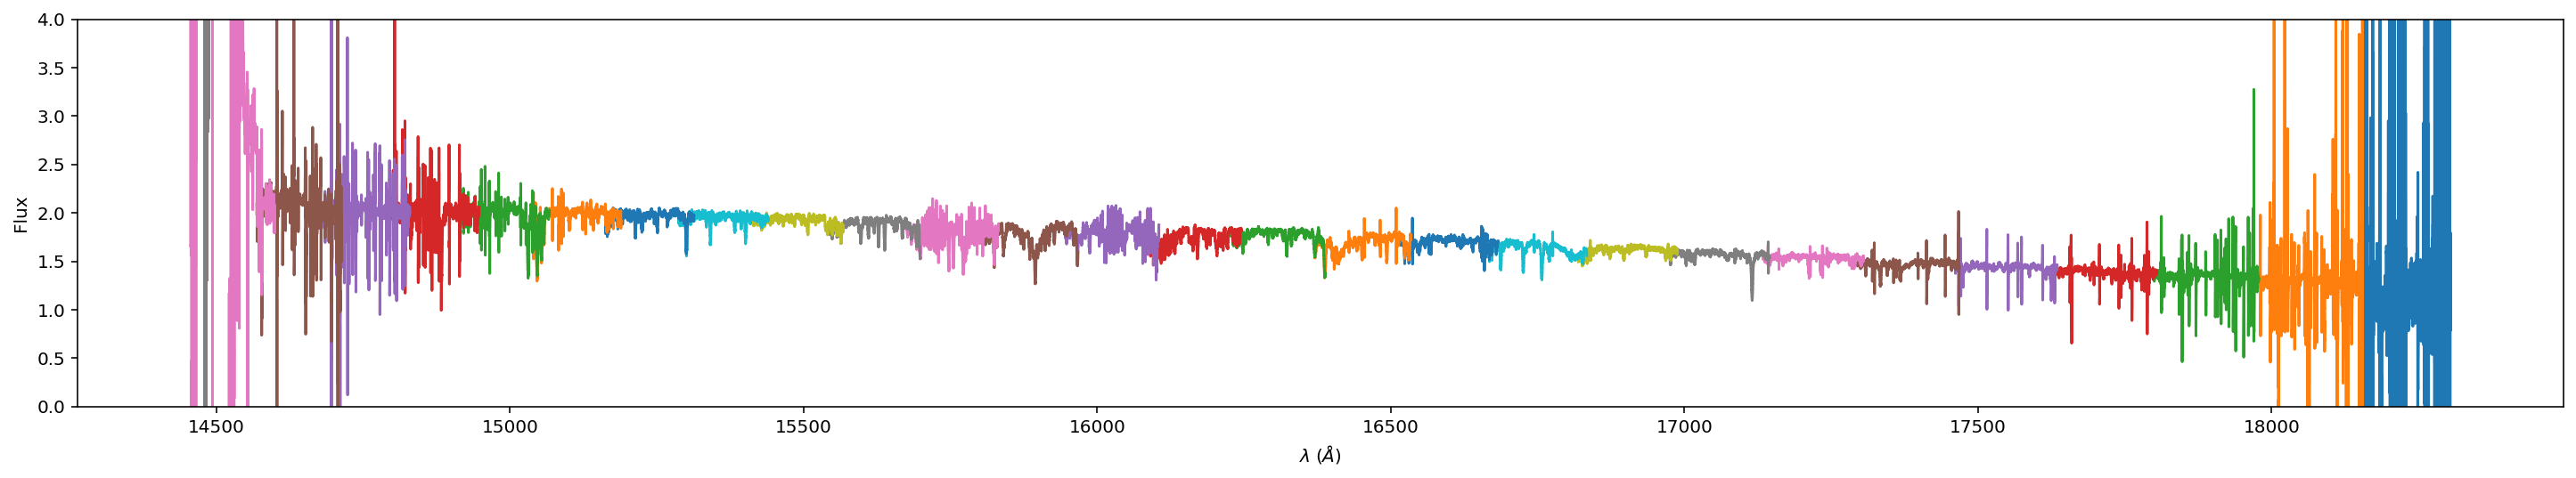

In [4]:
spec_list.remove_nans().trim_edges().normalize().plot(color=None, ylo=0, yhi=4);

## Workarounds

Here we introduce workarounds to three friction points.


### Issue 1: Slicing a `IGRINSSpectrumList`

First, we want to be able to index into the `IGRINSSpectrumList` in the same way you would with a regular old Python List, and still *get back* an `IGRINSSpectrumList`.

In [5]:
type(spec_list)

muler.igrins.IGRINSSpectrumList

In [6]:
sublist = spec_list[4:7]

In [7]:
type(sublist)

list

No! We want this sublist to be an `IGRINSSpectrumList`

In [8]:
sublist_IGRINS = IGRINSSpectrumList(sublist)

In [9]:
type(sublist_IGRINS)

muler.igrins.IGRINSSpectrumList

Yay! This workaround achieved our goal.

### Issue 2: Create an `IGRINSSpectrum` from a bare (`flux`, `wavelength`) array

Often we have already preprocessed a spectrum and have it in-hand as a pair of wavelength coordinates and flux values.  We wish to turn this most elemental format of a spectrum into a `IGRINSSpectrum`.

In [10]:
import astropy.units as u

In [11]:
whole_spectrum = spec_list.remove_nans().trim_edges().normalize().stitch()

In [12]:
len(whole_spectrum.flux.value)

39651

In [13]:
wavelength = whole_spectrum.wavelength.value
flux = whole_spectrum.flux.value

Can we "round-trip" this pair of coordinates and flux values back into an `IGRINSSpectrum`?

In [14]:
roundtrip_spec = IGRINSSpectrum(spectral_axis=wavelength*u.Angstrom, 
                                flux=flux*u.dimensionless_unscaled, )

In [15]:
type(roundtrip_spec)

muler.igrins.IGRINSSpectrum

Some methods will work out-of-the-box:

In [16]:
roundtrip_spec.normalize() # works fine!

<Spectrum1D(flux=<Quantity [ 1.07619306, -2.43560127, -0.94303922, ...,  2.01626181,
            2.14903611,  2.0957242 ]>, spectral_axis=<SpectralAxis [18154.20024475, 18154.33239657, 18154.46452956, ..., 14487.01715592,
   14487.10481695, 14487.19247083] Angstrom>)>

But others do not!

In [17]:
output = whole_spectrum.barycentric_correct() # works fine!

Watch out! This next line will not work!

In [18]:
roundtrip_spec.barycentric_correct() # Oops! Will not work!

KeyError: 'header'

### Issue 3: Applying a boolean mask to an `IGRINSSpectrumList`

We may want to apply a boolean mask, rather than mere slices.

In [ ]:
target_indices = [4, 6, 7]
all_orders = np.arange(0, 27)
boolean_mask = np.isin(all_orders, target_indices)
boolean_mask

How can we apply this mask?

In [ ]:
spec_list[boolean_mask] # Does not work!